In [ ]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict, Annotated , Literal , List
from langchain_groq import ChatGroq
from pydantic import Field , BaseModel  # For the Structured Ouput From the LLM model...
from langchain_core.messages import HumanMessage, SystemMessage # For Assigning role to LLM and How the Output of the LLM should be...
import os
import operator # For maintaining the history...

In [137]:
## Model Definitions:
generator_model=ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=os.getenv("API_KEY")
)

Evaluator_model=ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=os.getenv("API_KEY")
)   

optimizer_model=ChatGroq(
    model="llama-3.1-8b-instant",
    api_key=os.getenv("API_KEY")
)

In [138]:
class TweetEvaluation(BaseModel):
    evaluation: Literal["Approved", "Improvement Needed"] = Field(...,description="Final decision on whether the tweet is acceptable or requires improvement.")
    feedback: str = Field(...,description="A short paragraph explaining the reasoning behind the evaluation.")

In [139]:
Structured_evaluator_model=Evaluator_model.with_structured_output(TweetEvaluation)

In [140]:
### State Definitions:
class tweetState(TypedDict):
    topic: str
    tweet: str
    evaluation: Literal["Approved","Improvement Needed"]
    feedback: str
    iteration: int
    max_iterations: int

    tweet_history:Annotated[List[str],operator.add]   ## Merge all the Tweet that has been generated...
    feedback_history:Annotated[List[str],operator.add]  ## merge all the feedback That has been generated...
    

In [141]:
def generate_tweet(state:tweetState):
    topic=state["topic"]
    messages=[SystemMessage(content="You are a social media expert specializing in crafting engaging tweets."),
              HumanMessage(content=f"Generate a concise and engaging tweet about the following topic: {topic}. Keep it under 280 characters.\nGoals:\n->Keep it concise, punchy, and engaging.\nWriting Rules:\n1.Max 280 characters.\n2.Strong hook. No fluff.\n3.Clear spacing.\n4. Dont use Question-answer format. Modern creator tone.\n5.Use curiosity, authority, contrarian insight, or actionable value.")]
    tweet=generator_model.invoke(messages).content
    state["tweet"]=tweet

    return {"tweet":tweet,'tweet_history':[tweet]}


In [142]:
def evaluate_tweet(state: tweetState):
    message = [
        SystemMessage(
            content=(
                "You are an extremely strict evaluator. You MUST obey formatting rules perfectly. "
                "If the output would violate the rules, rewrite the feedback so that it does NOT "
                "contain forbidden characters. You MUST call the TweetEvaluation function."
            )
        ),

        HumanMessage(
            content=f"""
Evaluate this tweet STRICTLY:

Tweet: {state['tweet']}

STRICT APPROVAL RULES:
- If ANY improvement is possible, evaluation MUST be "Improvement Needed".
- Approve ONLY if the tweet is flawless, viral-level quality, and cannot be made better.

FORBIDDEN CHARACTERS (DO NOT USE IN FEEDBACK UNDER ANY CIRCUMSTANCE):
- Apostrophes (')
- Quotes (")
- Backslashes (\)
- Markdown (#, *, _, `)
- Emojis

If the natural wording would contain these characters, REWRITE the sentence so it avoids them.
Example:
Instead of "India's Railway", write "Indias Railway"
Instead of "it's", write "it is"
Instead of "Did you know?", write: Did you know

OUTPUT FORMAT (MUST MATCH EXACTLY):

{{ 
  "evaluation": "Approved" OR "Improvement Needed", 
  "feedback": "<one short paragraph with NO forbidden characters>"
}}

DO NOT escape anything.
DO NOT add extra fields.
DO NOT add commentary outside the JSON.
"""
        )
    ]

    response = Structured_evaluator_model.invoke(message)
    return {"evaluation": response.evaluation, "feedback": response.feedback , "feedback_history":[response.feedback]}

In [143]:
def optimize_tweet(state: tweetState):
    message = [
    SystemMessage(
        content=(
            f"""You are a tweet-optimization agent. Your job is to revise the user's tweet 
            using the evaluator's {state['feedback']}. Maintain the original intent, but fix all issues
            highlighted by the evaluation. Think internally, but output ONLY the final improved
            tweet in the required JSON format."""
           
        )
    ),
    HumanMessage(
        content=(
            f"Draft Tweet:\n{state['tweet']}\n\n"
            f"Evaluator Feedback:\n{state['feedback']}\n\n"
            "Optimization Rules:\n"
            "- Stay under 280 characters.\n"
            "- Address every point raised by the evaluator.\n"
            "- Strengthen the hook.\n"
            "- Improve clarity and punchiness.\n"
            "- Maintain the original meaning.\n"
            "- Remove filler and clichés.\n"
            "- Use emojis only if they add clarity.\n\n"
            "Output Format (JSON-like):\n"
           "Output Requirements:- You MUST call the TweetEvaluation function All strings must be plain text ONLY. Do NOT escape characters.- Do NOT include backslashes.- Do NOT include quotes inside the feedback text.- Do NOT use markdown symbols (no #, *, _, `, or emojis).- Feedback must be a simple, clean paragraph with normal sentences."
            "{ optimized_tweet: \"<final improved tweet>\" }"
        )
    )
]

    reponse=optimizer_model.invoke(message).content
    iteration=state['iteration']+1

    return {'tweet':reponse,'iteration':iteration,'tweet_history':[reponse]}


In [144]:
def eval_router(state:tweetState):

    if state['evaluation']=='Approved' or state['iteration']>=state['max_iterations']:
        return 'Approved'
    else:
        return 'Improvement Needed'

In [145]:
### Defining Graph:
graph=StateGraph(tweetState)


### Adding Nodes:
graph.add_node(name="generate_tweet",node=generate_tweet)
graph.add_node(name="evaluate_tweet",node=evaluate_tweet)
graph.add_node(name="optimize_tweet",node=optimize_tweet)

### Defining Edges:
graph.add_edge(START,'generate_tweet')
graph.add_edge('generate_tweet','evaluate_tweet')
graph.add_conditional_edges('evaluate_tweet',eval_router,{'Approved':END,'Improvement Needed':'optimize_tweet'})
graph.add_edge('optimize_tweet','evaluate_tweet')

workflow=graph.compile()



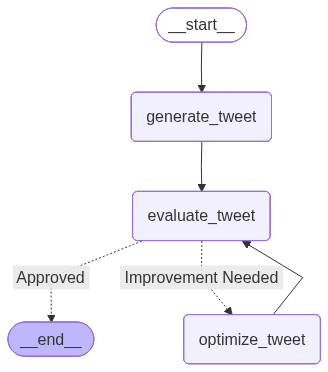

In [146]:
workflow

In [148]:
###
initial_state={
    'topic':"Indian Railway",
    'iteration':1,
    'max_iterations':5
}

result=workflow.invoke(initial_state)

In [150]:
for tweet in result['tweet_history']:
    print(tweet)

"Did you know? India's railway network is so extensive that it's considered one of the world's largest employers, with over 1.4 million staff members! #IndianRailways #RailwayNetwork"
{
  "optimized_tweet": "India's massive railway network employs a staggering 1.4 million staff members, making it one of the world's largest employers.",
  "feedback": "The tweet now opens with a stronger hook, India's massive railway network, to draw the reader in. The phrase 'Did you know' has been removed and the sentence rephrased to improve clarity and punchiness. The original meaning is maintained, but filler and clichés have been avoided. The tweet stays under 280 characters and hashtags have been removed to avoid spam."
}
{
  "optimized_tweet": "India's vast railway network employs 1.4 million staff, making it one of the world's largest employers.",
  "feedback": "The tweet is well structured, but the phrase 'massive railway network' was shortened for better clarity and flow. This change maintains